### Importing packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import re
import string

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

### Loading Dataset

In [7]:
true_path = "/Users/irray/Desktop/Projects/Fake News Classifier/dataset/True.csv"
fake_path = "/Users/irray/Desktop/Projects/Fake News Classifier/dataset/Fake.csv"

df_true = pd.read_csv(true_path)
df_fake = pd.read_csv(fake_path)

In [8]:
def clean_text(text):
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

if __name__ == "__main__":
    sample_text = "Some text (Reuters) with https://example.com, numbers123, and <html>tags</html>!"
    cleaned = clean_text(sample_text)
    print("Original:", sample_text)
    print("Cleaned:", cleaned)

Original: Some text (Reuters) with https://example.com, numbers123, and <html>tags</html>!
Cleaned: Some text with and tags


In [9]:
def detect_text_col(df):
    candidates = ["text", "content", "article", "title"]
    for c in candidates:
        if c in df.columns:
            return c
    return df.columns[0] 

In [10]:
tc_true = detect_text_col(df_true)
tc_fake = detect_text_col(df_fake)

df_true = df_true.rename(columns={tc_true: "text"})[["text"]].copy()
df_fake = df_fake.rename(columns={tc_fake: "text"})[["text"]].copy()

df_true["label"] = 0  
df_fake["label"] = 1  

df = pd.concat([df_true, df_fake], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)
print("Dataset shape:", df.shape)

Dataset shape: (44898, 2)


### Train-Test Split

In [11]:
X = df["text"].astype(str)
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

### TF-IDF Vectorizer

In [12]:
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,2), stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

### Training Model using Logistic Regression

In [13]:
model = LogisticRegression(max_iter=200, solver="saga", n_jobs=-1, verbose=0)
model.fit(X_train_tfidf, y_train)

log_reg = model
y_pred = model.predict(X_test_tfidf)

### Evaluation

In [14]:
accuracy_lr = accuracy_score(y_test, y_pred)
precision_lr = precision_score(y_test, y_pred)
recall_lr = recall_score(y_test, y_pred)
f1_lr = f1_score(y_test, y_pred)

print("\nLOGISTIC REGRESSION PERFORMANCE METRICS:")
print("=" * 40)
print(f"Accuracy:  {accuracy_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall:    {recall_lr:.4f}")
print(f"F1 Score:  {f1_lr:.4f}")

print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred, target_names=["True", "Fake"]))


LOGISTIC REGRESSION PERFORMANCE METRICS:
Accuracy:  0.9882
Precision: 0.9895
Recall:    0.9879
F1 Score:  0.9887

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        True       0.99      0.99      0.99      4284
        Fake       0.99      0.99      0.99      4696

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



### Training model using Naive Bayes Classification

In [15]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

### Evaluation

In [16]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

print("\nNAIVE BAYES PERFORMANCE METRICS:")
print("=" * 40)
print(f"Accuracy:  {accuracy_nb:.4f}")
print(f"Precision: {precision_nb:.4f}")
print(f"Recall:    {recall_nb:.4f}")
print(f"F1 Score:  {f1_nb:.4f}")

print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_nb, target_names=["True", "Fake"]))


NAIVE BAYES PERFORMANCE METRICS:
Accuracy:  0.9482
Precision: 0.9438
Recall:    0.9580
F1 Score:  0.9509

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        True       0.95      0.94      0.95      4284
        Fake       0.94      0.96      0.95      4696

    accuracy                           0.95      8980
   macro avg       0.95      0.95      0.95      8980
weighted avg       0.95      0.95      0.95      8980



### Training Model using Linear SVC

In [17]:
svc_model = LinearSVC(random_state=42, max_iter=1000)
svc_model.fit(X_train_tfidf, y_train)

y_pred_svc = svc_model.predict(X_test_tfidf)

### Evaluation

In [18]:
accuracy_svc = accuracy_score(y_test, y_pred_svc)
precision_svc = precision_score(y_test, y_pred_svc)
recall_svc = recall_score(y_test, y_pred_svc)
f1_svc = f1_score(y_test, y_pred_svc)

print("\nLINEAR SVC PERFORMANCE METRICS:")
print("=" * 40)
print(f"Accuracy:  {accuracy_svc:.4f}")
print(f"Precision: {precision_svc:.4f}")
print(f"Recall:    {recall_svc:.4f}")
print(f"F1 Score:  {f1_svc:.4f}")

print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_svc, target_names=["True", "Fake"]))


LINEAR SVC PERFORMANCE METRICS:
Accuracy:  0.9952
Precision: 0.9957
Recall:    0.9951
F1 Score:  0.9954

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        True       0.99      1.00      0.99      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Training Model using Random Forest

In [19]:
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    n_jobs=-1,  
    max_depth=None, 
    min_samples_split=2,
    min_samples_leaf=1
)
rf_model.fit(X_train_tfidf, y_train)

y_pred_rf = rf_model.predict(X_test_tfidf)

### Evaluation

In [20]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("\nRANDOM FOREST PERFORMANCE METRICS:")
print("=" * 40)
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")

print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_rf, target_names=["True", "Fake"]))


RANDOM FOREST PERFORMANCE METRICS:
Accuracy:  0.9969
Precision: 0.9979
Recall:    0.9962
F1 Score:  0.9970

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Training Model using XGBoost

In [21]:
xgb_model = XGBClassifier(
    random_state=42,
    n_jobs=-1,  
    eval_metric='logloss',
    use_label_encoder=False,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb_model.predict(X_test_tfidf)

/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [02:46:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Evaluation

In [22]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("\nXGBOOST PERFORMANCE METRICS:")
print("=" * 40)
print(f"Accuracy:  {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall:    {recall_xgb:.4f}")
print(f"F1 Score:  {f1_xgb:.4f}")

print("\nClassification Report:")
print("-" * 40)
print(classification_report(y_test, y_pred_xgb, target_names=["True", "Fake"]))


XGBOOST PERFORMANCE METRICS:
Accuracy:  0.9971
Precision: 0.9983
Recall:    0.9962
F1 Score:  0.9972

Classification Report:
----------------------------------------
              precision    recall  f1-score   support

        True       1.00      1.00      1.00      4284
        Fake       1.00      1.00      1.00      4696

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



### Comparative Analysis

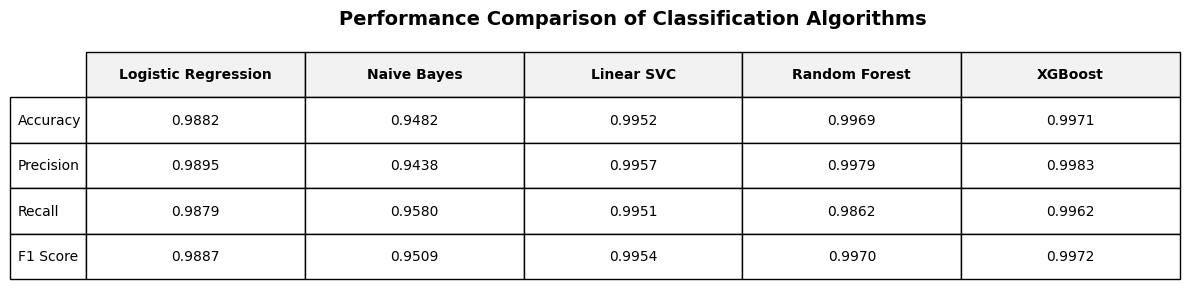

In [23]:
algorithms = ['Logistic Regression', 'Naive Bayes', 'Linear SVC', 'Random Forest', 'XGBoost']
accuracy_scores = [0.9882, 0.9482, 0.9952, 0.9969, 0.9971]
precision_scores = [0.9895, 0.9438, 0.9957, 0.9979, 0.9983]
recall_scores = [0.9879, 0.9580, 0.9951, 0.9862, 0.9962]
f1_scores = [0.9887, 0.9509, 0.9954, 0.9970, 0.9972]

cell_text = [
    [f'{acc:.4f}' for acc in accuracy_scores],
    [f'{prec:.4f}' for prec in precision_scores],
    [f'{rec:.4f}' for rec in recall_scores],
    [f'{f1:.4f}' for f1 in f1_scores]
]

plt.figure(figsize=(12, 3))
plt.axis('off')

table = plt.table(cellText=cell_text,
                  rowLabels=['Accuracy', 'Precision', 'Recall', 'F1 Score'],
                  colLabels=algorithms,
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

for i in range(5):  
    for j in range(1): 
        if i == 0 or j == 0:  
            cell = table[j, i]  
            cell.set_facecolor('#f2f2f2')
            cell.set_text_props(weight='bold')

plt.title('Performance Comparison of Classification Algorithms', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

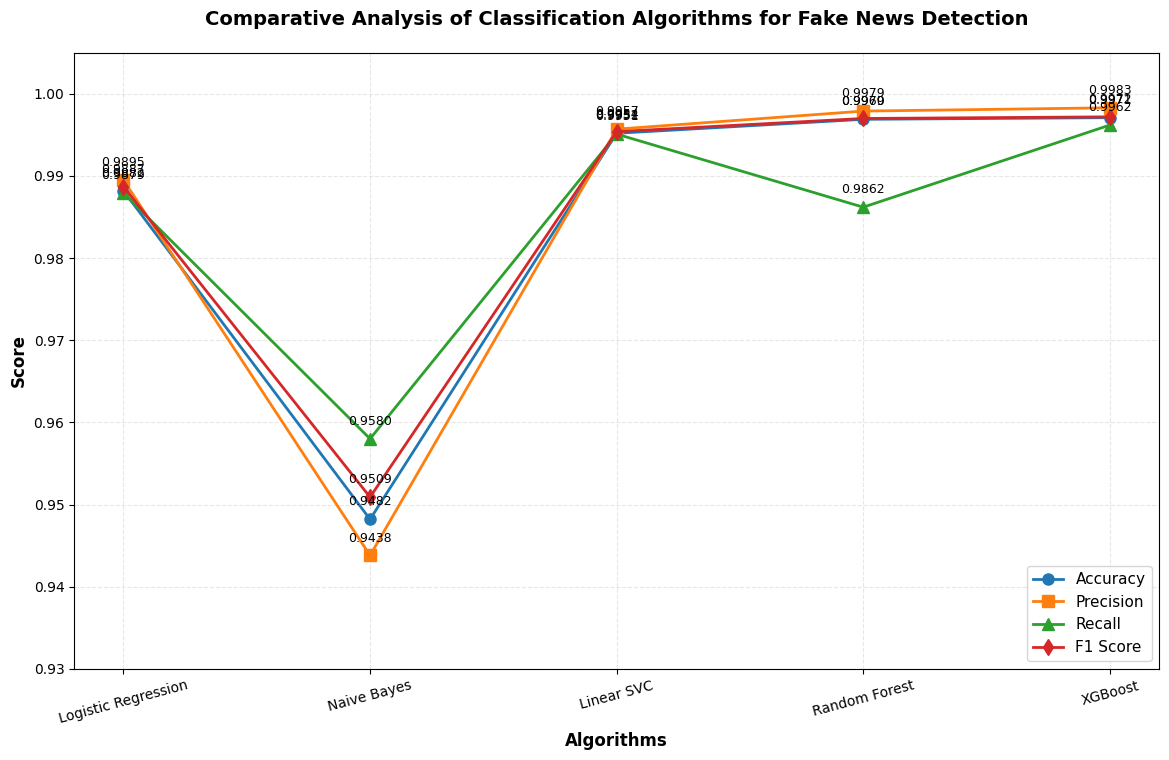

In [24]:
algorithms = ['Logistic Regression', 'Naive Bayes', 'Linear SVC', 'Random Forest', 'XGBoost']
accuracy_scores = [0.9882, 0.9482, 0.9952, 0.9969, 0.9971]
precision_scores = [0.9895, 0.9438, 0.9957, 0.9979, 0.9983]
recall_scores = [0.9879, 0.9580, 0.9951, 0.9862, 0.9962]
f1_scores = [0.9887, 0.9509, 0.9954, 0.9970, 0.9972]

plt.figure(figsize=(14, 8))
x_pos = np.arange(len(algorithms))

plt.plot(x_pos, accuracy_scores, 'o-', linewidth=2, markersize=8, label='Accuracy', color='#1f77b4')
plt.plot(x_pos, precision_scores, 's-', linewidth=2, markersize=8, label='Precision', color='#ff7f0e')
plt.plot(x_pos, recall_scores, '^-', linewidth=2, markersize=8, label='Recall', color='#2ca02c')
plt.plot(x_pos, f1_scores, 'd-', linewidth=2, markersize=8, label='F1 Score', color='#d62728')

plt.xlabel('Algorithms', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Comparative Analysis of Classification Algorithms for Fake News Detection', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(x_pos, algorithms, rotation=15)
plt.ylim(0.93, 1.005)  
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='lower right', fontsize=11)

for i, (acc, prec, rec, f1) in enumerate(zip(accuracy_scores, precision_scores, recall_scores, f1_scores)):
    plt.annotate(f'{acc:.4f}', (i, acc), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'{prec:.4f}', (i, prec), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'{rec:.4f}', (i, rec), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)
    plt.annotate(f'{f1:.4f}', (i, f1), textcoords="offset points", xytext=(0,10), ha='center', fontsize=9)

plt.show()

### Saving Model + Vectorization for WebApp

In [25]:
# Create models directory if it doesn't exist
os.makedirs("../models", exist_ok=True)  

# Save the vectorizer
with open("../models/vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Save the Linear SVC model
with open("../models/svc_model.pkl", "wb") as f:
    pickle.dump(svc_model, f)

print("✅ Linear SVC model and vectorizer saved successfully!")

✅ Linear SVC model and vectorizer saved successfully!


In [ ]:
def wordopt(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def output_label(n):
    if n == 0:
        return "True News"
    elif n == 1:
        return "Fake News"

def manual_testing(news):
    testing_news = {"text":[news]}
    new_def_test = pd.DataFrame(testing_news)
    new_def_test["text"] = new_def_test["text"].apply(wordopt) 
    new_x_test = new_def_test["text"]
    new_xv_test = vectorizer.transform(new_x_test)
    
    pred_LR = log_reg.predict(new_xv_test)
    pred_NB = nb_model.predict(new_xv_test)
    pred_SVC = svc_model.predict(new_xv_test)
    pred_RF = rf_model.predict(new_xv_test)
    pred_XGB = xgb_model.predict(new_xv_test)

    return print(f"""
    Logistic Regression Prediction: {output_label(pred_LR[0])}
    Naive Bayes Prediction: {output_label(pred_NB[0])}
    Linear SVC Prediction: {output_label(pred_SVC[0])}
    Random Forest Prediction: {output_label(pred_RF[0])}
    XGBoost Prediction: {output_label(pred_XGB[0])}
    """)

sample_news = "BRUSSELS  - NATO allies on Tuesday welcomed President Donald Trump s decision to commit more forces to Afghanistan, as part of a new U.S. strategy he said would require more troops and funding from America s partners. Having run for the White House last year on a pledge to withdraw swiftly from Afghanistan, Trump reversed course on Monday and promised a stepped-up military campaign against Taliban insurgents, saying: Our troops will fight to win . U.S. officials said he had signed off on plans to send about 4,000 more U.S. troops to add to the roughly 8,400 now deployed in Afghanistan. But his speech did not define benchmarks for successfully ending the war that began with the U.S.-led invasion of Afghanistan in 2001, and which he acknowledged had required an extraordinary sacrifice of blood and treasure . We will ask our NATO allies and global partners to support our new strategy, with additional troops and funding increases in line with our own. We are confident they will, Trump said. That comment signaled he would further increase pressure on U.S. partners who have already been jolted by his repeated demands to step up their contributions to NATO and his description of the alliance as obsolete - even though, since taking office, he has said this is no longer the case. NATO Secretary General Jens Stoltenberg said in a statement: NATO remains fully committed to Afghanistan and I am looking forward to discussing the way ahead with (Defense) Secretary (James) Mattis and our Allies and international partners. NATO has 12,000 troops in Afghanistan, and 15 countries have pledged more, Stoltenberg said. Britain, a leading NATO member, called the U.S. commitment very welcome . In my call with Secretary Mattis yesterday we agreed that despite the challenges, we have to stay the course in Afghanistan to help build up its fragile democracy and reduce the terrorist threat to the West, Defence Secretary Michael Fallon said. Germany, which has borne the brunt of Trump s criticism over the scale of its defense spending, also welcomed the new U.S. plan. Our continued commitment is necessary on the path to stabilizing the country, a government spokeswoman said. In June, European allies had already pledged more troops but had not given details on numbers, waiting for the Trump administration to outline its strategy for the region.Nearly 16 years after the U.S.-led invasion - a response to the Sept. 11 attacks which were planned by al Qaeda leader Osama bin Laden from Afghanistan - the country is still struggling with weak central government and a Taliban insurgency. Trump said he shared the frustration of the American people who were weary of war without victory , but a hasty withdrawal would create a vacuum for groups like Islamic State and al Qaeda to fill."

manual_testing(sample_news)


    Logistic Regression Prediction: True News
    Naive Bayes Prediction: True News
    Linear SVC Prediction: True News
    Random Forest Prediction: True News
    XGBoost Prediction: Fake News
    


In [28]:
sample_news = "Vic Bishop Waking TimesOur reality is carefully constructed by powerful corporate, political and special interest sources in order to covertly sway public opinion. Blatant lies are often televised regarding terrorism, food, war, health, etc. They are fashioned to sway public opinion and condition viewers to accept what have become destructive societal norms.The practice of manipulating and controlling public opinion with distorted media messages has become so common that there is a whole industry formed around this. The entire role of this brainwashing industry is to figure out how to spin information to journalists, similar to the lobbying of government. It is never really clear just how much truth the journalists receive because the news industry has become complacent. The messages that it presents are shaped by corporate powers who often spend millions on advertising with the six conglomerates that own 90% of the media:General Electric (GE), News-Corp, Disney, Viacom, Time Warner, and CBS. Yet, these corporations function under many different brands, such as FOX, ABC, CNN, Comcast, Wall Street Journal, etc, giving people the perception of choice   As Tavistock s researchers showed, it was important that the victims of mass brainwashing not be aware that their environment was being controlled; there should thus be a vast number of sources for information, whose messages could be varied slightly, so as to mask the sense of external control. ~ Specialist of mass brainwashing, L. WolfeNew Brainwashing Tactic Called AstroturfWith alternative media on the rise, the propaganda machine continues to expand. Below is a video of Sharyl Attkisson, investigative reporter with CBS, during which she explains how  astroturf,  or fake grassroots movements, are used to spin information not only to influence journalists but to sway public opinion. Astroturf is a perversion of grassroots. Astroturf is when political, corporate or other special interests disguise themselves and publish blogs, start facebook and twitter accounts, publish ads, letters to the editor, or simply post comments online, to try to fool you into thinking an independent or grassroots movement is speaking. ~ Sharyl Attkisson, Investigative ReporterHow do you separate fact from fiction? Sharyl Attkisson finishes her talk with some insights on how to identify signs of propaganda and astroturfing  These methods are used to give people the impression that there is widespread support for an agenda, when, in reality, one may not exist. Astroturf tactics are also used to discredit or criticize those that disagree with certain agendas, using stereotypical names such as conspiracy theorist or quack. When in fact when someone dares to reveal the truth or questions the  official  story, it should spark a deeper curiosity and encourage further scrutiny of the information.This article (Journalist Reveals Tactics Brainwashing Industry Uses to Manipulate the Public) was originally created and published by Waking Times and is published here under a Creative Commons license with attribution to Vic Bishop and WakingTimes.com. It may be re-posted freely with proper attribution, author bio, and this copyright statement. READ MORE MSM PROPAGANDA NEWS AT: 21st Century Wire MSM Watch Files"
manual_testing(sample_news)


    Logistic Regression Prediction: Fake News
    Naive Bayes Prediction: Fake News
    Linear SVC Prediction: Fake News
    Random Forest Prediction: Fake News
    XGBoost Prediction: Fake News
    


In [27]:
manual_testing(" Cesar Mata Pires, the owner and co-founder of Brazilian engineering conglomerate OAS SA, one of the largest companies involved in Brazil s corruption scandal, died on Tuesday. He was 68. Mata Pires died of a heart attack while taking a morning walk in an upscale district of S o Paulo, where OAS is based, a person with direct knowledge of the matter said. Efforts to contact his family were unsuccessful. OAS declined to comment. The son of a wealthy cattle rancher in the northeastern state of Bahia, Mata Pires links to politicians were central to the expansion of OAS, which became Brazil s No. 4 builder earlier this decade, people familiar with his career told Reuters last year. His big break came when he befriended Antonio Carlos Magalh es, a popular politician who was Bahia governor several times, and eventually married his daughter Tereza. Brazilians joked that OAS stood for Obras Arranjadas pelo Sogro - or Work Arranged by the Father-In-Law. After years of steady growth triggered by a flurry of massive government contracts, OAS was ensnared in Operation Car Wash which unearthed an illegal contracting ring between state firms and builders. The ensuing scandal helped topple former Brazilian President Dilma Rousseff last year. Trained as an engineer, Mata Pires founded OAS with two colleagues in 1976 to do sub-contracting work for larger rival Odebrecht SA - the biggest of the builders involved in the probe. Before the scandal, Forbes magazine estimated Mata Pires fortune at $1.6 billion. He dropped off the magazine s billionaire list in 2015, months after OAS sought bankruptcy protection after the Car Wash scandal. While Mata Pires was never accused of wrongdoing in the investigations, creditors demanded he and his family stay away from the builder s day-to-day operations, people directly involved in the negotiations told Reuters at the time. He is survived by his wife and his two sons.")


    Logistic Regression Prediction: True News
    Naive Bayes Prediction: True News
    Linear SVC Prediction: True News
    Random Forest Prediction: True News
    XGBoost Prediction: True News
    
